# Neural Networks for Data Science Applications
## End-of-term homework: Recurrent neural networks and autoregressive modelling

**Name**: *Danial Abri*

**Matricola**: *1763128*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 20th** session, you should upload it by **January 17th, 23:59 Rome time**.

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.4 MB/s eta 0:00:00


In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jrand
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, GPT2TokenizerFast
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from jax import random, jit, lax
import time
import os

In [ ]:
# Print hardware information
print("JAX devices:", jax.devices())
print("JAX default device:", jax.default_backend())
SEED = 55
np.random.seed(SEED)

JAX devices: [CudaDevice(id=0)]
JAX default device: gpu


### Instructions

1. The homework is divided into three exercises. The first two (**10 points**) are mandatory for everyone. The third one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2025).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>. **Same goes for LLM-generated material**.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and JAX*: the homework must be done _fully in JAX_ (no external libraries) and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

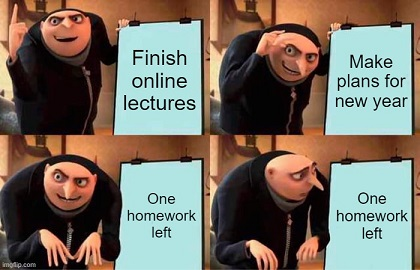

## Warmup: Data loading

For this part, select a dataset that is adequate for an autoregressive modelling task, keeping in mind task complexity with respect to the available hardware. Alternatively, take a generic dataset and transform it in a suitable way. Some examples (non exhaustive list):

1. Any text dataset can be converted to a next-token prediction dataset. You are free to use an existing tokenizer or train the tokenizer from scratch.
2. Time series are also naturally convertible to autoregressive scenarios.
3. For images you can convert them in multiple ways, e.g., as a sequence of pixels, as a sequence of patches (as in ViTs), as a sequence of bytes...
4. Other types of data, such as audio, graphs, DNA sequences, etc., are also feasible based on your interest.

> ⭕ For this homework, creativity is appreciated! Look around in the literature for inspiration (e.g., PixelRNN, pixel language modeling, audio autoregression, conditional models, ...). The fancier the better, according to your judgment.

*   You can use any data processing you want here (PyTorch data loaders, TensorFlow datasets, Grain, HuggingFace Dataset, ...).
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code. Describe the preprocessing you have applied. Show some examples of tokenized sequences and / or some statistics (e.g., tokens count, sequence length, ...).*

**TODO**: add description here (1-2 paragraphs).

# TinyStories Dataset Description

The TinyStories dataset is a collection of short stories. A synthetic dataset that only contains words that young children usually understand, generated by GPT.

* **Source:** Created by Eldan & Li (2023), ["TinyStories: How Small Can Language Models Be and Still Speak Coherent English?"](https://arxiv.org/abs/2305.07759)
* **Content:** Almost 2 million very short stories generated by GPT-3.5/4 constrained to simple vocabulary
* **Target audience:** Young children (age 3-4)
* **Language complexity:** Deliberately simplified with limited vocabulary (~10K words)
* **Story length:** Typically short, 200-500 words per story
* **Purpose:** Originally developed to study how small language models can be while maintaining coherent English

This dataset is particularly suitable for our RNN language model because:

* It contains grammatically correct but simple English
* The limited vocabulary and simpler sentence structures make it easier to model
* The stories maintain narrative coherence

## Data loading

In [ ]:
# Loading the TinyStories dataset
dataset = load_dataset("roneneldan/TinyStories")

# Checking out dataset's structure
print(f"Dataset structure: {dataset.keys()}")
print(f"Dataset size: {len(dataset)}")

# Reduce all splits to 25% of their original size
# This makes the training and evaluation process faster but still provides enough data for implementing RNN's behavior and capabilities.
train_size = int(len(dataset['train']) * 0.25)
val_size = int(len(dataset['validation']) * 0.25)
test_size = val_size
# Select subset of the data
dataset['train'] = dataset['train'].select(range(train_size))
dataset['test'] = dataset['validation'].select(range(test_size,test_size*2))
dataset['validation'] = dataset['validation'].select(range(val_size))

print("\nReduced dataset sizes (25% of all splits):")
for split in dataset:
    print(f"{split}: {len(dataset[split])} examples")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Dataset structure: dict_keys(['train', 'validation'])
Dataset size: 2

Reduced dataset sizes (25% of all splits):
train: 529929 examples
validation: 5497 examples
test: 5497 examples


In [30]:
# Seeing an example of the dataset
print("\nA sample story:\n")
print(dataset['train'][55]['text'])


A sample story:

Mommy and Emily were playing a matching game together. Emily was so excited to find the matching games at the store. She liked watching the videos on the screen as she matched each card.

"Mommy, I think I'm getting really good at this!" Emily said.

"That's wonderful, sweetheart!" Mommy replied. "You're doing so well!"

But then, Emily noticed something strange. She pulled out one of the cards and looked closely at it.

"Mommy, this card isn't real," she said. "It's fake!"

Mommy took the card and looked at it. "You're right," she said. "This card is fake. It doesn't match the others."

Mommy and Emily decided to get a new video game instead. Emily was happy to have an even better game to play. She could tell the difference between a real card and a fake one.


I chose the existing GPT-2 tokenizer and trained it for this task since:

* It's designed for generation: Created specifically for autoregressive prediction
* It has no artificial separators: Minimal special tokens mean cleaner text generation

In [ ]:
# Creating a simple tokenizer by loading GPT-2 tokenizer which was designed primarily for text generation and not batch processing
original_tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Getting a batch of text samples for building vocabulary
def batch_iterator():
    for i in range(0, len(dataset["train"]), 1000):
        yield dataset["train"][i:i+1000]["text"]

# Training tokenizer on new vocabulary
tokenizer = original_tokenizer.train_new_from_iterator(
    batch_iterator(),
    vocab_size=8000
)

# Saving the tokenizer
os.makedirs("tinystories_tokenizer", exist_ok=True)
tokenizer.save_pretrained("tinystories_tokenizer")

vocab_size = len(tokenizer)
print(f"Tokenizer vocabulary size: {vocab_size}")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizer vocabulary size: 8000


Here we see an example of how GPT-2 tokenizes text.

We see a special character Ġ for space in text. By doing this, it preserves spacing information, When decoding tokens back to text, the tokenizer knows where to insert spaces and also the model can learn different contexts for initial word versus internal word tokens.

In [ ]:
example_text = dataset['train'][55]['text'][:100]
print(f"Example: {example_text}")
tokens = tokenizer.encode(example_text)
print(f"Tokenized example: {tokenizer.convert_ids_to_tokens(tokens)}")
print(f"Token IDs: {tokens}")
print(f"Decoded back: {tokenizer.decode(tokens)}")

Example: Mommy and Emily were playing a matching game together. Emily was so excited to find the matching gam
Tokenized example: ['Mommy', 'Ġand', 'ĠEmily', 'Ġwere', 'Ġplaying', 'Ġa', 'Ġmatching', 'Ġgame', 'Ġtogether', '.', 'ĠEmily', 'Ġwas', 'Ġso', 'Ġexcited', 'Ġto', 'Ġfind', 'Ġthe', 'Ġmatching', 'Ġg', 'am']
Token IDs: [1296, 265, 2304, 427, 605, 259, 6076, 1261, 566, 14, 2304, 282, 353, 616, 266, 638, 263, 6076, 291, 333]
Decoded back: Mommy and Emily were playing a matching game together. Emily was so excited to find the matching gam


In [ ]:
seq_length = 64

# This function Tokenizes stories using GPT-2 tokenizer and creates fixed-length sequences for next-token prediction.
def tokenize_and_chunk(examples):

    # Tokenizing all texts
    tokenized = tokenizer(
        examples["text"],
        truncation=False,
        add_special_tokens=True,  # Adding EOS token at the end
    )

    # Concatenating all tokenized texts
    all_input_ids = []
    for input_ids in tokenized["input_ids"]:
        all_input_ids.extend(input_ids)
        all_input_ids.append(tokenizer.eos_token_id) # Adding an EOS token between examples

    # Chunking the data into sequences of seq_length + 1 (extra token for target)
    chunks = []
    for i in range(0, len(all_input_ids) - seq_length, seq_length):
        chunks.append(all_input_ids[i:i + seq_length + 1])

    # Filtering out chunks that are too short
    chunks = [chunk for chunk in chunks if len(chunk) == seq_length + 1]

    # Preparing input and target sequences
    inputs = [chunk[:-1] for chunk in chunks]
    targets = [chunk[1:] for chunk in chunks]

    return {"input_ids": inputs, "labels": targets}

In [ ]:
# Processing each split
processed_dataset = {}
for split in dataset.keys():
    processed_split = dataset[split].map(
        tokenize_and_chunk,
        batched=True,
        remove_columns=["text"]) # To save memory
    processed_dataset[split] = processed_split

# Printing number of seqs for each split
for split in processed_dataset:
    print(f"{split}: {len(processed_dataset[split])} sequences")

Map:   0%|          | 0/529929 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1188 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/5497 [00:00<?, ? examples/s]

Map:   0%|          | 0/5497 [00:00<?, ? examples/s]

train: 1832796 sequences
validation: 16971 sequences
test: 17955 sequences


In [ ]:
# Display a sample of our processed dataset
input_ids = processed_dataset['train'][2]['input_ids']
label_ids = processed_dataset['train'][2]['labels']
print("\nSample from processed dataset:")
print(f"Input sequence length: {len(input_ids)}")
print(f"Target sequence length: {len(label_ids)}")
print(f"Input: '{tokenizer.decode(input_ids)}'")
print(f"Target: '{tokenizer.decode(label_ids)}'")
print("\nNext-token prediction pattern:")
for i in range(5):
  input_token = tokenizer.decode([input_ids[i]])
  target_token = tokenizer.decode([label_ids[i]])
  print(f"  Input token: '{input_token}' ==> Target token: '{target_token}'")


Sample from processed dataset:
Input sequence length: 64
Target sequence length: 64
Input: ' each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.<|endoftext|>Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy'
Target: ' other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.<|endoftext|>Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car'

Next-token prediction pattern:
  Input token: ' each' ==> Target token: ' other'
  Input token: ' other' ==> Target token: '.'
  Input token: '.' ==> Target token: ' After'
  Input token: ' After' ==> Target token: ' they'
  Input token: ' they' ==> Target token: ' finished'


In order to load the data, I used Pytorch data loaders. I used [this link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for the instructions.


In [ ]:
# Creating the class for PyTorch data loaders
class TokenPredictionDataset(Dataset):
    def __init__(self, dataset_dict, split="train"):
        self.input_ids = dataset_dict[split]["input_ids"]
        self.labels = dataset_dict[split]["labels"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
# Creating dataloaders with appropriate batch size for L4 GPU
batch_size = 256
dataloaders = {}
for split in processed_dataset.keys():
    dataset_obj = TokenPredictionDataset(processed_dataset, split)
    dataloaders[split] = DataLoader(
        dataset_obj,
        batch_size=batch_size,
        shuffle=(split == "train")
    )

print(f"Batch size: {batch_size}")
for split, loader in dataloaders.items():
    print(f"{split}: {len(loader)} batches")

Batch size: 256
train: 7160 batches
validation: 67 batches
test: 71 batches


## Dataset statistics
In this cell I show some statistics in a sample of size 1000 from train dataset.

In [31]:
# Calculating dataset statistics on a sample of sequences
sample_size = 1000
samples = processed_dataset["train"]["input_ids"][:sample_size]
print(f"Number of sequences analyzed: {len(samples)}")

# Counting tokens
all_tokens = [token for seq in samples for token in seq]
unique_tokens = set(all_tokens)
print(f"Total tokens: {len(all_tokens)}")
print(f"Unique tokens: {len(unique_tokens)}")

# Counting token frequencies
token_counts = {}
for token in all_tokens:
    token_counts[token] = token_counts.get(token, 0) + 1

# Getting most common tokens
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
top_tokens = sorted_tokens[:10]

print("\nMost frequent tokens:")
for token_id, count in top_tokens:
    # Use new_tokenizer instead of tokenizer
    token_text = tokenizer.decode([token_id])
    print(f"Token {token_id} '{token_text}': {count} occurrences")

Number of sequences analyzed: 1000
Total tokens: 64000
Unique tokens: 3363

Most frequent tokens:
Token 14 '.': 3903 occurrences
Token 12 ',': 2525 occurrences
Token 263 ' the': 2398 occurrences
Token 199 '
': 2344 occurrences
Token 265 ' and': 2167 occurrences
Token 266 ' to': 1646 occurrences
Token 259 ' a': 1579 occurrences
Token 282 ' was': 1490 occurrences
Token 304 ' it': 707 occurrences
Token 327 ' said': 577 occurrences


### Exercise 1: Training a recurrent model (7 points)

For this exercise, you are asked to implement a recurrent neural network, **entirely in JAX** (no higher-level libraries). Examples include all the content of Lecture 10 in the course (vanilla RNNs, structured state-space models, ...) but also other types of recurrent models you may find in the literature.

> 🟨 Depending on the implementation, you may need to be careful in the forward pass. For example, consider using [jax.lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) for implementing the loop of a vanilla RNN.

> 🟥 Remember that the homework must be done fully in JAX, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Importantly, describe carefully the design of the model. Train the model and show some plots to visualize the training (e.g., loss curves, perplexity, ...).*

**TODO**: add description here (1-2 paragraphs).

# Part 2: Vanilla RNN Implementation

## Model Description and Design

I chose the vanilla RNN model which has these components:

1. **Embedding layer**: Converts token IDs to dense vectors
2. **Recurrent layer**: Processes sequences step-by-step, maintaining hidden state
3. **Output layer**: Projects hidden state to vocabulary space for next-token prediction

In addition I used:
* **lax.scan**: To handle sequential processing
* **Gradient clipping**: Prevents exploding gradients, a common issue in RNNs
* **Xavier/Glorot**: Also to solve the vanishing and exploding gradient problems

### Disclaimer:
- I have used Claude LLM to debug my model because of the vectorization problems that I was facing.

The RNN cell uses the classic tanh activation function:

$$h_t = \tanh(W_{ih} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)$$

- $h_t$ is the hidden state at time step $t$
- $W_{ih}$ is the input-to-hidden weight matrix
- $W_{hh}$ is the hidden-to-hidden weight matrix
- $x_t$ is the input at time step $t$
- $b_h$ is the hidden bias vector
- $\tanh$ is the hyperbolic tangent activation function



In [14]:
# This function initializes the parameters for our vanilla RNN
def init_rnn_params(rng_key, vocab_size, embedding_size, hidden_size):
    key1, key2, key3, key4 = random.split(rng_key, 4)

    # Xavier/Glorot initialization scales: I used this because without it, I got very irrelevant amount in loss and inf for perplexity
    embedding_scale = np.sqrt(1.0 / embedding_size)
    hidden_scale = np.sqrt(1.0 / hidden_size)

    return {
        'W_emb': random.normal(key1, (vocab_size, embedding_size))* embedding_scale,# Embedding matrix maps token IDs to vectors
        'W_ih': random.normal(key2, (embedding_size, hidden_size))* embedding_scale,# Input-to-hidden weights
        'W_hh': random.normal(key3, (hidden_size, hidden_size))* hidden_scale, # Hidden-to-hidden (recurrent) weights
        'b_h': jnp.zeros((hidden_size,)), # Hidden bias
        'W_ho': random.normal(key4, (hidden_size, vocab_size))* hidden_scale, # Output projection to vocabulary
        'b_o': jnp.zeros((vocab_size,)) # Output bias
    }

In [15]:
# In this function we do the forward pass for vanilla RNN
def rnn_forward(params, inputs, h_init = None):
    batch_size, seq_length = inputs.shape
    hidden_size = params['W_hh'].shape[0]

    if h_init is None:
        h_init = jnp.zeros((batch_size, hidden_size))

    # Embedding lookup for the entire sequence. the shape is: (batch_size, seq_length, embedding_size)
    embedded = params['W_emb'][inputs]

    # Single RNN step function with tanh for lax.scan
    def rnn_step(h_prev, x_t):
        h_new = jnp.tanh(jnp.dot(x_t, params['W_ih']) + jnp.dot(h_prev, params['W_hh']) + params['b_h'])
        logits = jnp.dot(h_new, params['W_ho']) + params['b_o']
        return h_new, (h_new, logits)

    # Transposing embedded to put sequence dimension first. embedded_seq Shape becomes: (seq_length, batch_size, embedding_size)
    embedded_seq = jnp.transpose(embedded, (1, 0, 2))

    # Scanning over the sequence dimension and saving the results
    final_state, scan_outputs = lax.scan(rnn_step, h_init, embedded_seq)
    hidden_states, logits_seq = scan_outputs

    # Transposing back to batch-first format. The shapes become: (batch_size, seq_length, vocab_size/hidden_size)
    logits_seq = jnp.transpose(logits_seq, (1, 0, 2))
    hidden_states = jnp.transpose(hidden_states, (1, 0, 2))

    return logits_seq, final_state, hidden_states

In [16]:
# This function computes cross-entropy loss and perplexity for language modeling.
@jit
def compute_loss_and_perplexity(params, inputs, targets):
    # Using the Forward pass function
    logits, final, hidden = rnn_forward(params, inputs)

    # Computing log-softmax
    log_probs = jax.nn.log_softmax(logits, axis=-1)

    # Getting log probs for target tokens
    target_log_probs = jnp.take_along_axis(log_probs,targets[..., jnp.newaxis],axis=-1).squeeze(-1)
    loss = -jnp.mean(target_log_probs)

    # Perplexity = exp(loss)
    perplexity = jnp.exp(loss)

    return loss, perplexity

In [ ]:
def compute_loss_and_perplexity(params, inputs, targets):
    # Forward pass
    logits, _, _ = rnn_forward(params, inputs)

    # Computing log-softmax
    log_probs = jax.nn.log_softmax(logits, axis=-1)

    # This function extracts target log probs for a single sequence
     # Get log probs for target tokens
    target_log_probs = jnp.take_along_axis(
        log_probs,
        targets[..., jnp.newaxis],
        axis=-1
    ).squeeze(-1)

    loss = -jnp.mean(target_log_probs)
    perplexity = jnp.exp(loss)

    return loss, perplexity

In [17]:
# This function does a Single training step with gradient clipping.
@jit
def train_step(params, inputs, targets, lr=0.001):

    # Computing loss and gradients together
    (loss, perplexity), grads = jax.value_and_grad(
        lambda p: compute_loss_and_perplexity(p, inputs, targets),
        has_aux=True
    )(params)

    # Computing gradient norm for clipping
    grad_norm = jnp.sqrt(sum(jnp.sum(g**2) for g in jax.tree_util.tree_leaves(grads)))
    # Clipping the gradients
    scale = jnp.minimum(1.0, max_grad_norm / (grad_norm + 1e-8))
    grads = jax.tree_map(lambda g: g * scale, grads)

    # Applying gradient descent update
    params = jax.tree_map(lambda p, g: p - lr * g, params, grads)

    return params, loss, perplexity

In [18]:
# This function does training loops with metrics tracking.
def train_rnn(params, dataloaders, num_epochs=5, learning_rate=0.001):

    # Initialize metrics dictionary
    metrics = {
        'train_losses': [],
        'val_losses': [],
        'train_perplexities': [],
        'val_perplexities': [],
        'epochs': [],
        'epoch_times': []
    }

    # JIT-compile the evaluation function
    eval_jit = jit(compute_loss_and_perplexity)

    print(f"Starting training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        start_time = time.time()

        epoch_loss = 0.0
        epoch_perplexity = 0.0
        num_batches = 0

        for batch in dataloaders['train']:
            # Converting PyTorch batch to JAX arrays
            inputs = jnp.array(batch['input_ids'].numpy())
            targets = jnp.array(batch['labels'].numpy())

            # Performing training step
            params, loss, perplexity = train_step(
                params, inputs, targets, learning_rate
            )

            epoch_loss += loss
            epoch_perplexity += perplexity
            num_batches += 1

        # Calculating average metrics
        avg_train_loss = epoch_loss / num_batches
        avg_train_perplexity = epoch_perplexity / num_batches

        # Evaluating also on validation set
        val_loss = 0.0
        val_perplexity = 0.0
        num_val_batches = 0

        for batch in dataloaders['validation']:
            inputs = jnp.array(batch['input_ids'].numpy())
            targets = jnp.array(batch['labels'].numpy())

            batch_loss, batch_perplexity = eval_jit(params, inputs, targets)

            val_loss += batch_loss
            val_perplexity += batch_perplexity
            num_val_batches += 1

        val_loss /= num_val_batches
        val_perplexity /= num_val_batches

        # Saving the necessary metrics
        metrics['train_losses'].append(float(avg_train_loss))
        metrics['val_losses'].append(float(val_loss))
        metrics['train_perplexities'].append(float(avg_train_perplexity))
        metrics['val_perplexities'].append(float(val_perplexity))
        metrics['epochs'].append(epoch + 1)

        # Calculating every epoch time
        epoch_time = time.time() - start_time
        metrics['epoch_times'].append(epoch_time)

        # Printing progress
        print(f"Epoch {epoch+1}/{num_epochs} ({epoch_time:.2f}s):")
        print(f"  Train Loss: {avg_train_loss:.4f}, Perplexity: {avg_train_perplexity:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Perplexity: {val_perplexity:.4f}")

    return params, metrics

In [19]:
# Setting the hyperparameters
embedding_size = 64
hidden_size = 128
learning_rate = 0.001
num_epochs = 20
max_grad_norm = 1.0   # Maximum gradient norm for clipping

In [20]:
# Initializing RNN parameters
rng_key = random.PRNGKey(SEED)
params = init_rnn_params(rng_key, vocab_size, embedding_size, hidden_size)

# Printing parameter shapes and total count
total_params = sum(np.prod(p.shape) for p in params.values())
print(f"Total parameters: {total_params:,}")
for name, param in params.items():
    print(f"{name}: {param.shape}")

# Training the model
print("\nStarting training...")
start_time = time.time()
trained_params, metrics = train_rnn(
    params,
    dataloaders,
    num_epochs=num_epochs,
    learning_rate=learning_rate
)
total_time = time.time() - start_time
print(f"\nTraining completed in {total_time//60:,} minutes and {total_time%60:.2f} seconds.")

Total parameters: 1,568,704
W_emb: (8000, 64)
W_ih: (64, 128)
W_hh: (128, 128)
b_h: (128,)
W_ho: (128, 8000)
b_o: (8000,)

Starting training...
Starting training for 20 epochs...


<ipython-input-17-13d4ce86d521>:15: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  grads = jax.tree_map(lambda g: g * scale, grads)


Epoch 1/20 (234.19s):
  Train Loss: 7.7058, Perplexity: 2796.1340
  Val Loss: 7.0213, Perplexity: 1122.6395
Epoch 2/20 (220.70s):
  Train Loss: 6.7625, Perplexity: 870.6626
  Val Loss: 6.6250, Perplexity: 756.8247
Epoch 3/20 (220.66s):
  Train Loss: 6.5046, Perplexity: 669.1584
  Val Loss: 6.4580, Perplexity: 641.1609
Epoch 4/20 (222.75s):
  Train Loss: 6.3672, Perplexity: 582.8450
  Val Loss: 6.3481, Perplexity: 574.8036
Epoch 5/20 (220.64s):
  Train Loss: 6.2665, Perplexity: 526.9423
  Val Loss: 6.2592, Perplexity: 526.1118
Epoch 6/20 (222.71s):
  Train Loss: 6.1787, Perplexity: 482.5935
  Val Loss: 6.1781, Perplexity: 485.3683
Epoch 7/20 (220.65s):
  Train Loss: 6.0993, Perplexity: 445.7366
  Val Loss: 6.1070, Perplexity: 452.2804
Epoch 8/20 (222.73s):
  Train Loss: 6.0297, Perplexity: 415.7780
  Val Loss: 6.0437, Perplexity: 424.7614
Epoch 9/20 (220.71s):
  Train Loss: 5.9666, Perplexity: 390.3206
  Val Loss: 5.9849, Perplexity: 400.6817
Epoch 10/20 (220.68s):
  Train Loss: 5.9086,

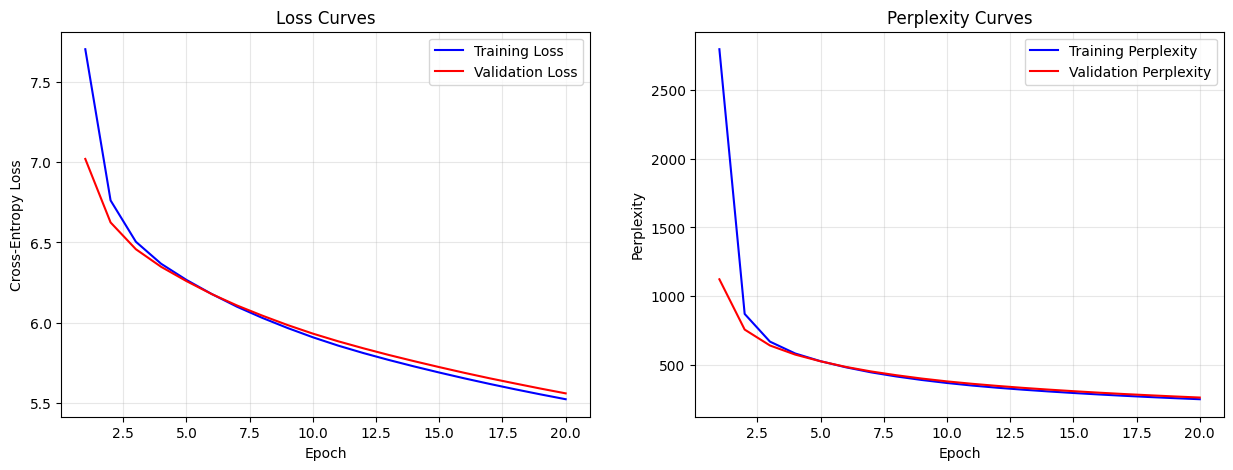

In [21]:
#Plotting training and validation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting losses
ax1.plot(metrics['epochs'], metrics['train_losses'], 'b-', label='Training Loss')
ax1.plot(metrics['epochs'], metrics['val_losses'], 'r-', label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plotting perplexities
ax2.plot(metrics['epochs'], metrics['train_perplexities'], 'b-', label='Training Perplexity')
ax2.plot(metrics['epochs'], metrics['val_perplexities'], 'r-', label='Validation Perplexity')
ax2.set_title('Perplexity Curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.legend()
ax2.grid(True, alpha=0.3)

#plt.tight_layout()
plt.show()

In [22]:
# Printing final metrics
print("Training Results:")
print(f"Final training loss: {metrics['train_losses'][-1]:.4f}")
print(f"Final validation loss: {metrics['val_losses'][-1]:.4f}")
print(f"Final training perplexity: {metrics['train_perplexities'][-1]:.4f}")
print(f"Final validation perplexity: {metrics['val_perplexities'][-1]:.4f}")

Training Results:
Final training loss: 5.5221
Final validation loss: 5.5587
Final training perplexity: 250.2572
Final validation perplexity: 262.4879


In [23]:
# Evaluating on the test set
print("\nEvaluating on test set...")
test_loss = 0.0
test_perplexity = 0.0
num_test_batches = 0

for batch in dataloaders['test']:
    inputs = jnp.array(batch['input_ids'].numpy())
    targets = jnp.array(batch['labels'].numpy())

    batch_loss, batch_perplexity = compute_loss_and_perplexity(trained_params, inputs, targets)
    test_loss += batch_loss
    test_perplexity += batch_perplexity
    num_test_batches += 1

test_loss /= num_test_batches
test_perplexity /= num_test_batches

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Perplexity: {test_perplexity:.4f}")


Evaluating on test set...
Test Loss: 5.5032
Test Perplexity: 248.4812


### Exercise 2: Autoregressive generation (3 points)

For this exercise, run the trained model in an autoregressive fashion and show some examples of generated sequences. Note that the details will depend on the specific type of data (e.g., sampling text tokens, sampling pixels as discrete values, sampling pixels from a continuous range of colours, ...). For this, refer also to Section 8.4 of the book.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Show some examples of generated sequences.*

**TODO**: add description here (1-2 paragraphs).


The text generation process converts a seed prompt into tokens, feeds them through the RNN to produce logits that represent next-token predictions, and then samples new tokens one-by-one while using the RNN's memory (hidden state) to maintain context throughout the generation.

By adjusting the temperature parameter, we can control whether the model produces more deterministic text (low temperature) or more creative and varied output (high temperature).

By the way since the perplexity of my model is around 250, We see almost random text generated so the results are not that satisfying to me.

In [27]:
def generate_text(params, seed_text, tokenizer, max_tokens=50, temperature=0.8):

    # Creating a random key
    key = random.PRNGKey(int(time.time() * 1000))

    # Tokenizing seed text
    seed_tokens = tokenizer.encode(seed_text)
    input_tokens = jnp.array([seed_tokens])
    h = None

    # Saving the generated tokens
    all_tokens = seed_tokens.copy()

    for _ in range(max_tokens):
        # Forward pass
        logits, h, _ = rnn_forward(params, input_tokens, h)

        # Getting logits for last token and applying temperature
        next_logits = logits[0, -1] / temperature

        # Applying softmax to get probabilities
        probs = jax.nn.softmax(next_logits)

        # Sampling next token
        key, subkey = random.split(key)
        next_token = random.categorical(subkey, probs.reshape(1, -1))[0]

        # Adding to generated tokens and updating input_tokens for next loop
        all_tokens.append(int(next_token))
        input_tokens = jnp.array([[next_token]])

    return tokenizer.decode(all_tokens)

In [32]:
# Prompts to test with
seed_texts = [
    "Once upon a time there was a",
    "The little girl was playing with her",
    "Alice told her brother to not to",
    "My favorite thing to do on weekends is"
]

temps = [0.2, 0.5, 0.8, 1.2, 1.5]

# Generating examples
for seed in seed_texts:
    print(f"\nSeed: {seed}")

    for temp in temps:
        generated = generate_text(
            params=trained_params,
            seed_text=seed,
            tokenizer=tokenizer,
            max_tokens=50,
            temperature=temp
        )

        print(f"Temperature {temp}: {generated}")
        print("---")


Seed: Once upon a time there was a
Temperature 0.2: Once upon a time there was aab steak scient inc cle almost daisieslooumpy Queen bir itemSure books respectful uncle embarrassedden wise Bum Likeges seartedœMy cushions Mabel insectuptort thu!", birdaws wakes reminder belly leather eats amazed happened bounceel paQu�imney discoveries waiter
---
Temperature 0.5: Once upon a time there was aag dishwasher designunday cho stubborn bouqu harbHarry cott tuckedquitoRuby�uxBabyissors enthusia counts spy streamMine hor need walked obserEllaœWhatâ interestingber wise fruit magnifebra peppers famous rocketpecially cliff� while neighbours gone sandwkendaclesaf restore sle smil
---
Temperature 0.8: Once upon a time there was a available feelings threat mastce bubblesmereduddenly GoodRoar fi clearing important investig carefulThanks Tessalous seawuffitting watch� further� Hop Binkyways fing cra gobbled sniffs school attract wandering hung worriedquit pound veil imagsing windThen tap someday moments

### Exercise 3: Beam search (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercises 1&2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1&2&3 for a total of *15 points*.

In standard autoregressive modeling, at every iteration you sample the element with the highest associated probability (e.g., the $\arg\max$ for a discrete distribution). This is known as **greedy decoding**. However, this may result in completed sequences with low probability.

A common modification is **beam search** ([link](https://d2l.ai/chapter_recurrent-modern/beam-search.html)), where at every iteration we keep track of $k$ possible sequences (called **beams**). See also Section 8.4.2 in the book.

**TODO**: For this exercise, implement a beam search decoding procedure for your model, and show some examples of generation, comparing them to the result of greedy decoding.

In [ ]:
# TODO: Your code here.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

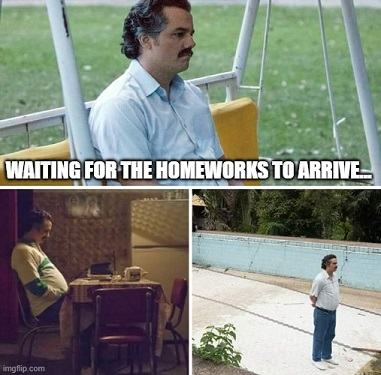